In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.DataFrame({"target":cancer.target})

df_cancer = pd.concat([y, X], axis=1)
print(df_cancer.shape)
df_cancer.head()

(569, 31)


,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
TEST_SIZE = 0.2
RANDOM_SEED = 2020
N_FOLD = 5

# DataCheck

## observation

In [4]:
def draw_histogram(x, title=None, xlabel=None):
    plt.title(title)
    plt.hist(x, color='blue', rwidth=0.9)
    plt.xlabel(xlabel)
    plt.show()

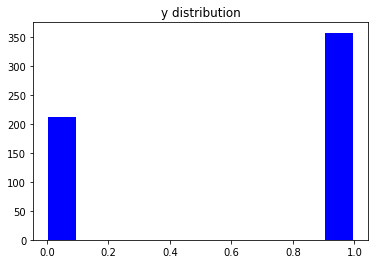

In [5]:
draw_histogram(y, 'y distribution')

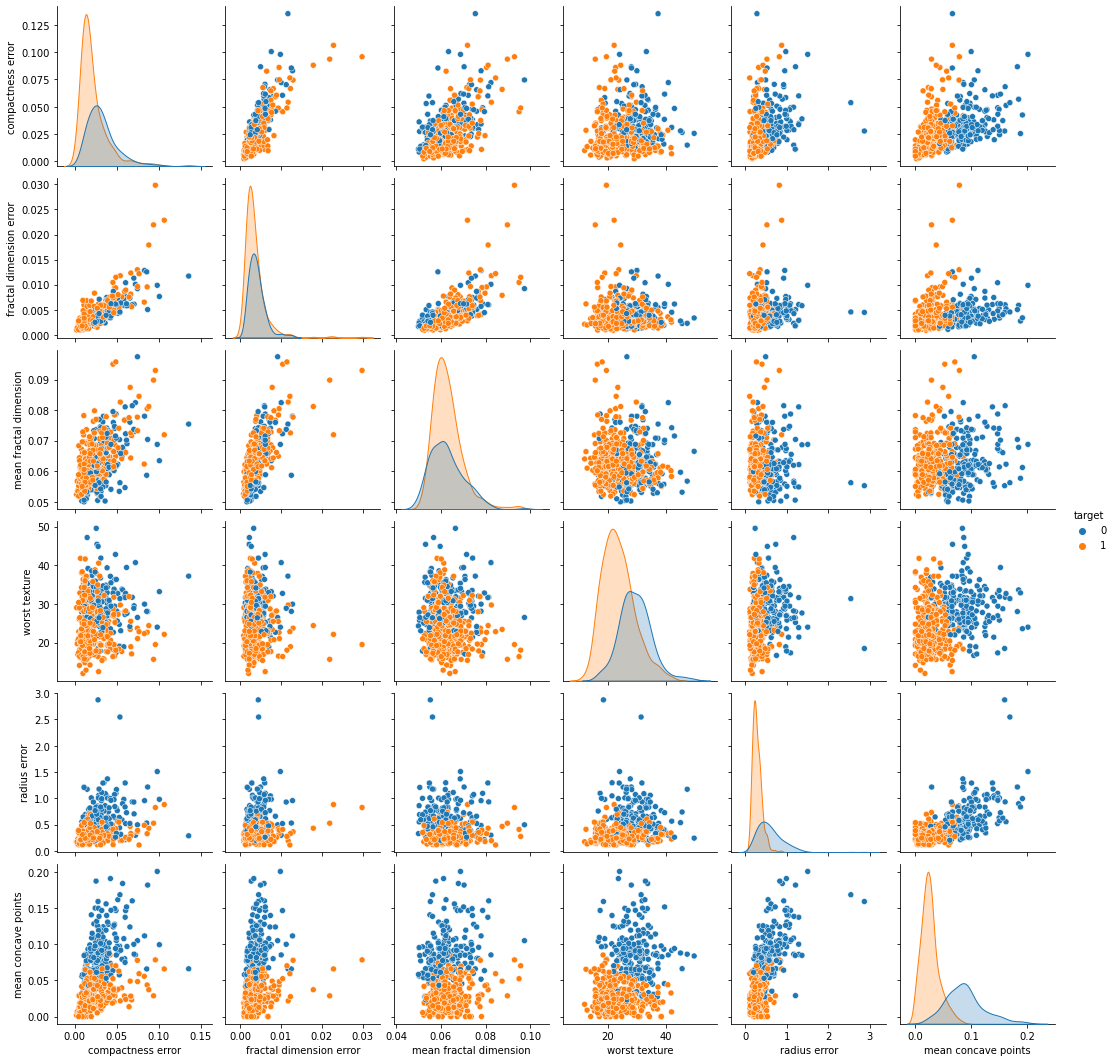

In [6]:
# example
sns.pairplot(df_cancer, hue="target", vars=[
    "compactness error", "fractal dimension error", "mean fractal dimension",
    "worst texture", "radius error", "mean concave points",
])

In [7]:
# # TODO: feature selection
# sns.pairplot(X)

## Interpretating by gml

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

lr = LogisticRegression(C=0.01)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [9]:
print('confusion matrix: ', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy: ', accuracy_score(y_true=y_test , y_pred=y_pred))
print('precision: ', precision_score(y_true=y_test , y_pred=y_pred))
print('recall: ', recall_score(y_true=y_test , y_pred=y_pred))
print('f1 score: ', f1_score(y_true=y_test , y_pred=y_pred))

confusion matrix:  [[44  4]
 [ 0 66]]
accuracy:  0.9649122807017544
precision:  0.9428571428571428
recall:  1.0
f1 score:  0.9705882352941176


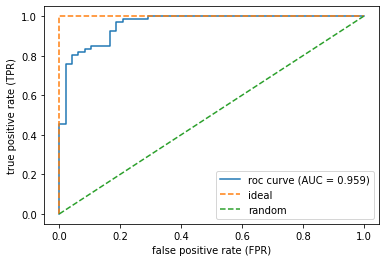

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

y_score = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)

plt.plot(fpr,tpr,label='roc curve (AUC = %0.3f)' % auc(fpr,tpr))
plt.plot([0,0,1], [0,1,1], linestyle='--', label='ideal')
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.legend()
plt.xlabel('false positive rate (FPR)')
plt.ylabel('true positive rate (TPR)')
plt.show()

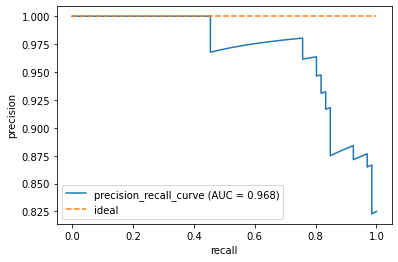

In [11]:
probas_pred = lr.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_score)
 
plt.plot(recall,precision,label='precision_recall_curve (AUC = %0.3f)' % auc(recall,precision))
plt.plot([0,1], [1,1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

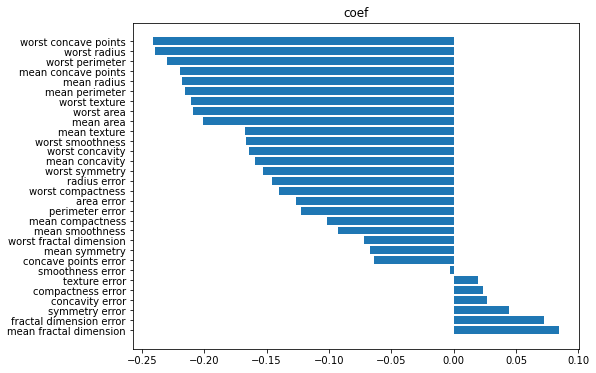

In [12]:
plt.figure(figsize=(8, 6))

df_coef = pd.DataFrame({"columns": X.columns, "coef": lr.coef_[0].tolist()}).sort_values("coef", ascending=False)
plt.barh(width=list(df_coef["coef"]), y=df_coef["columns"])
plt.title(f"coef")
plt.show()

# SHAP

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
model = xgb.train(
    {"learning_rate": 0.01},
    xgb.DMatrix(X_train, label=y_train),
    100,
) # don't have to use .fit()

In [14]:
shap.initjs()
explainer = shap.TreeExplainer(
    model=model,
    data=X_test,
    feature_perturbation="interventional",
)
shap_values = explainer(X_test)

## for a certain instance

### waterfall plot

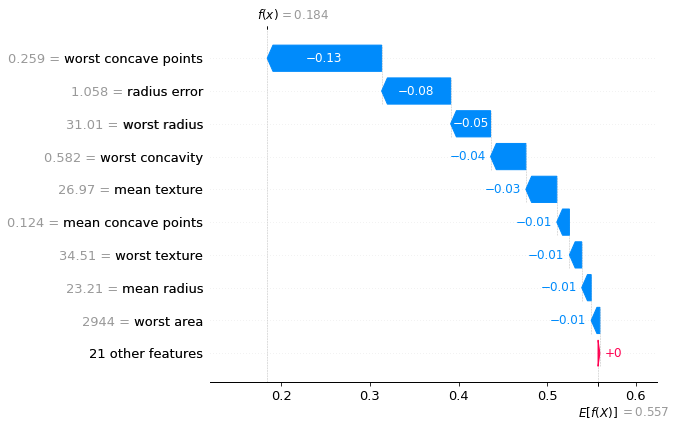

In [15]:
shap.plots.waterfall(shap_values[0])

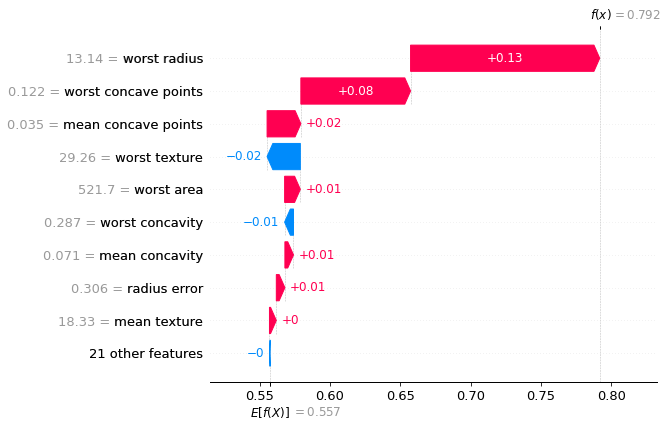

In [16]:
shap.plots.waterfall(shap_values[1])

### force plot for each flag

--------- label: 0, idx: 0 ---------


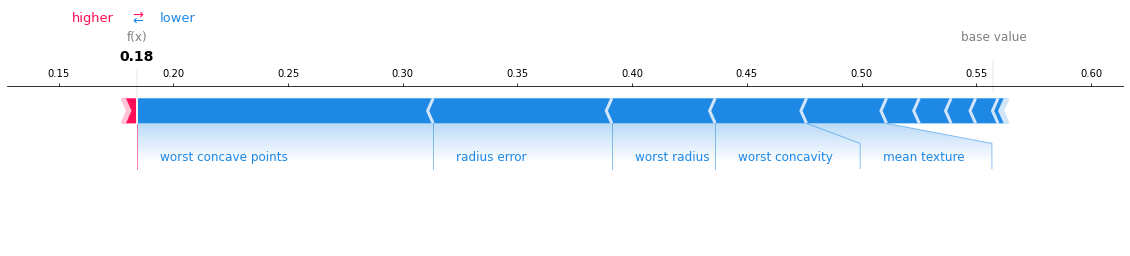

--------- label: 0, idx: 3 ---------


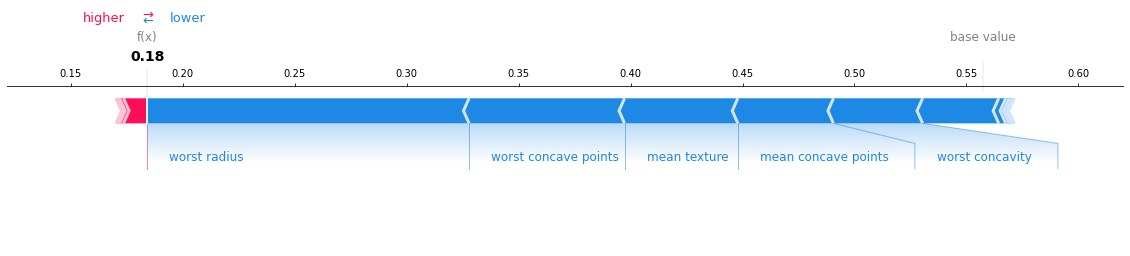

--------- label: 0, idx: 6 ---------


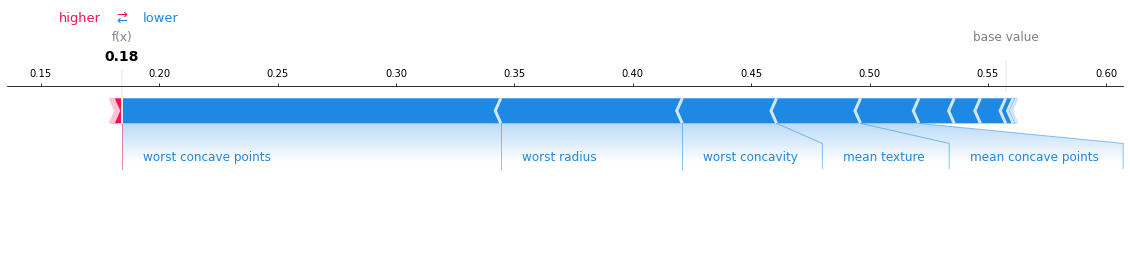

--------- label: 1, idx: 1 ---------


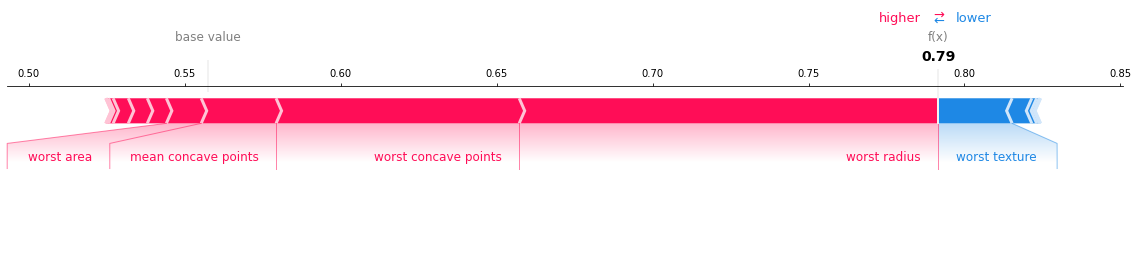

--------- label: 1, idx: 2 ---------


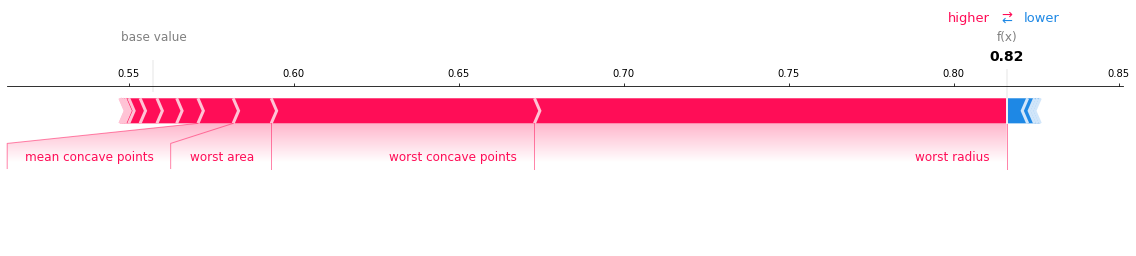

--------- label: 1, idx: 4 ---------


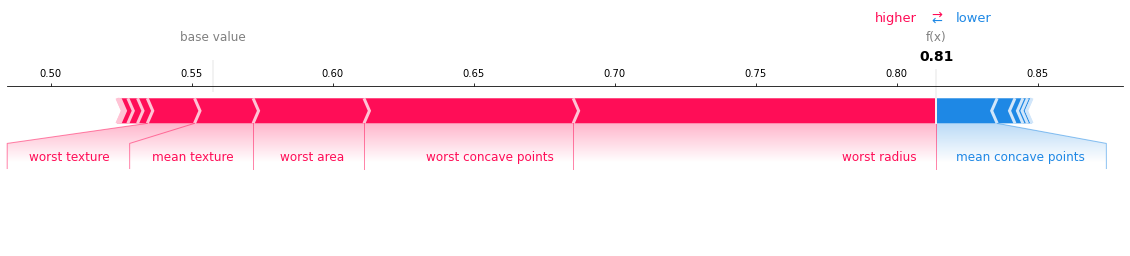

In [17]:
y_test_copy = y_test.reset_index(drop=True)

for flag in [0, 1]:
    idxs = y_test_copy[y_test_copy["target"]==flag].index[0:3]
    
    for idx in idxs:
        print(f"--------- label: {flag}, idx: {idx} ---------")
        shap.force_plot(
            base_value=explainer.expected_value,
            shap_values=shap_values.values[idx, :],
            feature_names=X.columns,
            matplotlib=True,
        )

## for whole instances

### feature plot

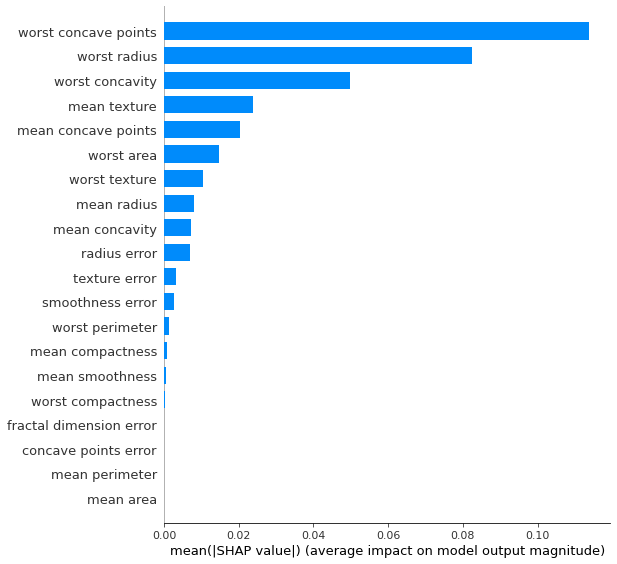

In [18]:
shap.summary_plot(shap_values, plot_type="bar")

### beamwarm plot

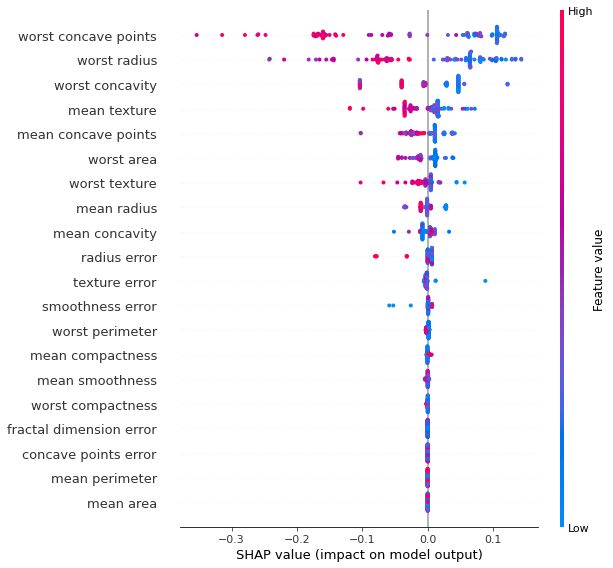

In [19]:
# color: Feature value
# x: shap value
# y: features
shap.summary_plot(shap_values)

### dependence plot

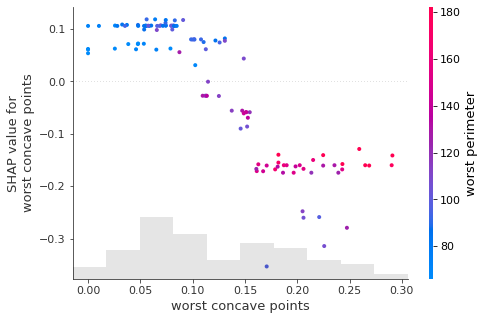

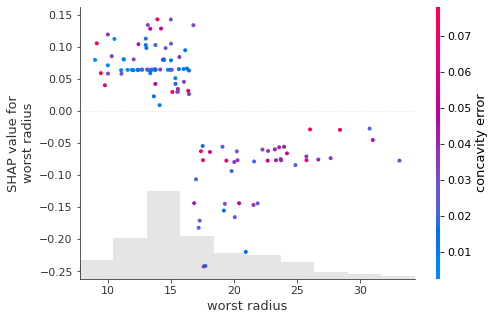

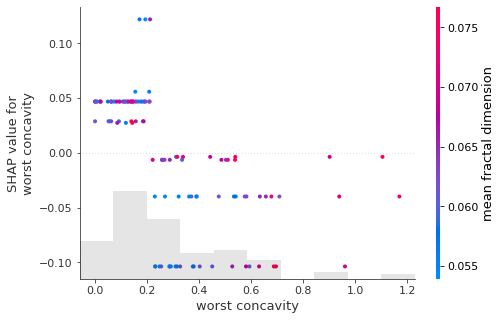

In [20]:
# color: automaticaly selected feature, has a large impact
# x: feature value
# y: shap value
for col in ["worst concave points", "worst radius", "worst concavity"]:
    shap.plots.scatter(shap_values[:, col], color=shap_values)
    
# -> ex> worst perimeter が小さいインスタンスほど， shap for worst concave points が大きくなっている

### force plot

In [21]:
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values.values,
    features=X.columns,
)

see also: https://shap.readthedocs.io/en/latest/tabular_examples.html